In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import dictys
from dictys.net import stat
import joblib

In [2]:
from utils_custom import *

In [3]:
# Define file paths 
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output'

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file(os.path.join(output_folder, 'dynamic.h5'))

# Rank TFs unbiasedly based on their expression and regulation curve chars

# Get the top genes of TF subnetworks based on the beta curve chars

In [5]:
# load ranked TFs list 
ranked_tfs_pb = pd.read_csv(os.path.join(output_folder, 'ranked_tfs_pb.csv'))
pb_top_tfs = ranked_tfs_pb[0:15]
#convert to list of TF_name
pb_top_tfs_list = pb_top_tfs['TF_name'].tolist()
# get tf_indices from pb_top_tfs_list
tf_indices_top_pb_tfs, _, _ = get_tf_indices(dictys_dynamic_object, pb_top_tfs_list)
display(tf_indices_top_pb_tfs)

[225, 305, 25, 150, 243, 251, 299, 303, 68, 36, 48, 133, 46, 118, 134]

In [7]:
# get the edge strengths of the top tfs with all relevant genes (dropping genes based on sparsity)
pts, fsmooth = dictys_dynamic_object.linspace(0,2,100,0.0005)
stat1_net = fsmooth(stat.net(dictys_dynamic_object))
stat1_netbin = stat.fbinarize(stat1_net,sparsity=0.01)

In [35]:
stat1_x=stat.pseudotime(dictys_dynamic_object,pts)
dtime = pd.Series(stat1_x.compute(pts)[0])

In [10]:
# compute the binary network to get the indices of genes to keep based on sparsity
dnetbin = stat1_netbin.compute(pts)

In [11]:
display(dnetbin.shape)

(551, 11907, 100)

In [32]:
subnetworks_bin = dnetbin[np.ix_(tf_indices_top_pb_tfs, range(dnetbin.shape[1]), range(dnetbin.shape[2]))]
display(subnetworks_bin.shape)

(15, 11907, 100)

In [33]:
# Calculate sparsity for each gene (across all TFs and timepoints)
# Mean across TFs (axis 0) and time (axis 2)
gene_density = (subnetworks_bin != 0).mean(axis=(0, 2))  # Shape: (11907,)
# Keep genes that are non-zero more than 20% of the time
genes_to_keep = gene_density > 0.05
genes_to_keep_indices = np.where(genes_to_keep)[0]
# Create reverse mapping: index -> gene_name
ndict = dictys_dynamic_object.ndict
index_to_gene = {idx: name for name, idx in ndict.items()}
# Get gene names for kept indices directly
kept_target_names = [index_to_gene[idx] for idx in genes_to_keep_indices]
print(len(genes_to_keep_indices))

647


In [29]:
dnet = stat1_net.compute(pts)
display(dnet.shape)

(551, 11907, 100)

In [30]:
# Filter the subnetworks array to keep only non-sparse genes
filtered_subnetworks = dnet[np.ix_(tf_indices_top_pb_tfs,genes_to_keep_indices, range(dnet.shape[2]))]
print(filtered_subnetworks.shape)

(15, 647, 100)


In [34]:
# Create multi-index tuples (all combinations of TF-target pairs)
index_tuples = [(tf, target) for tf in pb_top_tfs_list for target in kept_target_names]
multi_index = pd.MultiIndex.from_tuples(index_tuples, names=['TF', 'Target'])
# Reshape the subnetworks array to 2D (pairs × time points)
n_tfs, n_targets, n_times = filtered_subnetworks.shape
reshaped_data = filtered_subnetworks.reshape(-1, n_times)

# Create DataFrame with multi-index
betas_dcurve = pd.DataFrame(
    reshaped_data,
    index=multi_index,
    columns=[f'time_{i}' for i in range(n_times)]
)
display(betas_dcurve.head())

time_0    time_1    time_2    time_3    time_4    time_5  \
TF    Target                                                               
PRDM1 ABCC1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
      ACADM   0.022965  0.023116  0.023237  0.023335  0.023417  0.023492   
      ACADVL -0.000126 -0.000105 -0.000087 -0.000072 -0.000058 -0.000047   
      ACAP1  -0.001366 -0.001227 -0.001097 -0.000975 -0.000863 -0.000759   
      ACAT2   0.002176  0.002328  0.002477  0.002622  0.002761  0.002893   

                time_6    time_7    time_8    time_9  ...       time_90  \
TF    Target                                          ...                 
PRDM1 ABCC1   0.000000  0.000000  0.000000  0.000000  ...  0.000000e+00   
      ACADM   0.023570  0.023663  0.023781  0.023938  ...  8.242913e-02   
      ACADVL -0.000037 -0.000029 -0.000022 -0.000017  ...  2.175080e-18   
      ACAP1  -0.000665 -0.000579 -0.000502 -0.000434  ... -1.034296e-17   
      ACAT2   0.003016  0.003128  0.003229  0.003318  ...  1.137932e-10   

                   time_91       time_92       time_93       time_94  \
TF    Target                                                           
PRDM1 ABCC1   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      ACADM   8.101511e-02  7.948645e-02  7.785483e-02  7.613230e-02   
      ACADVL  1.180057e-18  6.384289e-19  3.444578e-19  1.853553e-19   
      ACAP1  -5.570750e-18 -2.992482e-18 -1.603353e-18 -8.569104e-19   
      ACAT2   7.304838e-11  4.676898e-11  2.986679e-11  1.902533e-11   

                   time_95       time_96       time_97       time_98  \
TF    Target                                                           
PRDM1 ABCC1   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      ACADM   7.433100e-02  7.246304e-02  7.054028e-02  6.857421e-02   
      ACADVL  9.948320e-20  5.325988e-20  2.844365e-20  1.515421e-20   
      ACAP1  -4.568560e-19 -2.429902e-19 -1.289409e-19 -6.826717e-20   
      ACAT2   1.208974e-11  7.664277e-12  4.847544e-12  3.059112e-12   

                   time_99  
TF    Target                
PRDM1 ABCC1   0.000000e+00  
      ACADM   6.657586e-02  
      ACADVL  8.055118e-21  
      ACAP1  -3.606439e-20  
      ACAT2   1.926275e-12  

[5 rows x 100 columns]

In [36]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
import math
from tqdm import tqdm

def process_chunk(args):
    """Process a chunk of curves to compute characteristics"""
    chunk_df, dtime = args
    results = {}
    for idx in chunk_df.index:
        curve = chunk_df.loc[idx]
        char_dict = compute_curve_characteristics(pd.DataFrame(curve).T, dtime)
        results[idx] = char_dict.iloc[0]
    return pd.DataFrame.from_dict(results, orient='index')

# Split data into chunks
n_cores = 8  # Adjust based on your CPU
chunk_size = math.ceil(len(betas_dcurve) / n_cores)
chunks = []

for i in range(0, len(betas_dcurve), chunk_size):
    chunk = betas_dcurve.iloc[i:i + chunk_size]
    chunks.append((chunk, dtime))

# Process chunks in parallel with progress bar
with Pool(n_cores) as pool:
    results = list(tqdm(
        pool.imap(process_chunk, chunks),
        total=len(chunks),
        desc="Processing curves"
    ))

# Combine results and sort
final_dchar = pd.concat(results).sort_index()
final_dchar.to_csv(os.path.join(output_folder, 'betas_chars_15_647.csv'))


Processing curves: 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


In [62]:
display(final_dchar.head())

Terminal logFC  Transient logFC  Switching time
BHLHE41 ABCC1         0.000000         0.000000        0.000000
        ACADM         0.000000         0.000000        0.000000
        ACADVL        0.061963        -0.027798        0.926312
        ACAP1         0.155953        -0.012183        0.567255
        ACAT2        -0.066738        -0.014691        0.466751

In [38]:
def get_top_curves_by_category(dchar, ntops=(20,20,30,30)):
    """
    Get top curves for different patterns based on Terminal and Transient logFC.
    
    Parameters:
    -----------
    dchar : pd.DataFrame
        DataFrame with curve characteristics, having multi-index (TF, Target)
        and columns ['Terminal logFC', 'Transient logFC', 'Switching time']
    ntops : tuple
        Number of top curves to return for (activating, inactivating, transient_up, transient_down)
    """
    categories = {}
    
    # Activating (positive Terminal logFC)
    t1 = dchar.sort_values('Terminal logFC', ascending=False).head(ntops[0])
    categories['activating'] = t1.sort_values('Switching time')
    
    # Inactivating (negative Terminal logFC)
    t1 = dchar.sort_values('Terminal logFC', ascending=True).head(ntops[1])
    categories['inactivating'] = t1.sort_values('Switching time')
    
    # Transient up
    t1 = dchar.sort_values('Transient logFC', ascending=False).head(ntops[2])
    categories['transient_up'] = t1
    
    # Transient down
    t1 = dchar.sort_values('Transient logFC', ascending=True).head(ntops[3])
    categories['transient_down'] = t1
    
    # Extract TF-target pairs for each category
    activating_pairs = [(idx[0], idx[1]) for idx in categories['activating'].index]
    inactivating_pairs = [(idx[0], idx[1]) for idx in categories['inactivating'].index]
    transient_up_pairs = [(idx[0], idx[1]) for idx in categories['transient_up'].index]
    transient_down_pairs = [(idx[0], idx[1]) for idx in categories['transient_down'].index]
    
    return {
        'activating': activating_pairs,
        'inactivating': inactivating_pairs,
        'transient_up': transient_up_pairs,
        'transient_down': transient_down_pairs
    }

In [39]:
sorted_categories = get_top_curves_by_category(final_dchar, ntops=(20,20,30,30))

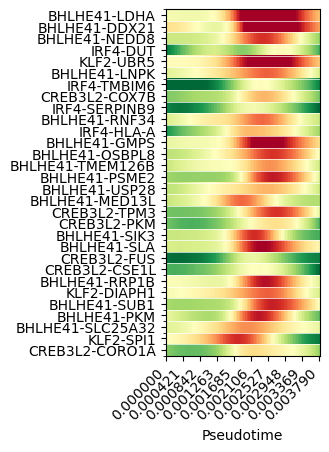

In [46]:
fig, ax, dnet = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=2,
    regulations=sorted_categories['transient_down'],
    num=100,
    dist=0.0005,
    cmap='RdYlGn' #red is low, green is high
)

In [47]:
# Convert dnet to DataFrame with row labels
df = pd.DataFrame(dnet, 
                 index=["-".join(x) for x in sorted_categories['transient_down']])
print("DataFrame values range:", df.values.min(), "to", df.values.max())
# Calculate max absolute value for symmetric color scaling
vmax_val = float(df.abs().values.max())  # Get max from numpy array values

DataFrame values range: -0.45411423323397027 to 0.28250742483385227


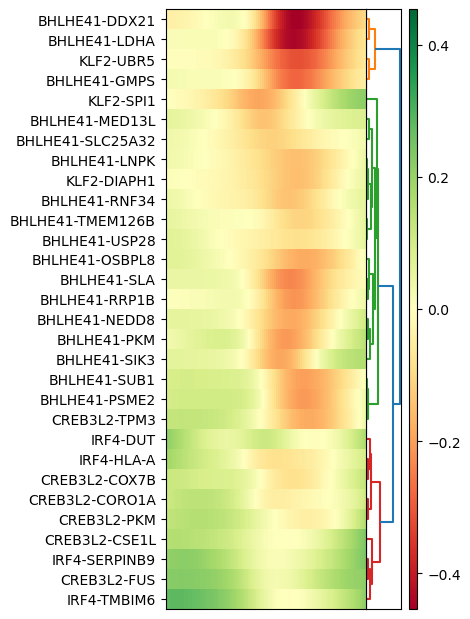

In [48]:
# Use cluster_heatmap with absolute values for clustering
fig, x, y = cluster_heatmap(df.abs(),  # Use absolute values for clustering
                           dshow=df,    # Show original values in heatmap
                           dtop=0,      # No clustering on time points
                           dright=0.3,  # Cluster the links
                           method='ward',
                           metric='euclidean',
                           cmap='RdYlGn',   # Use the colormap name directly
                           aspect=0.1,
                           xtick=False,
                           vmin=-vmax_val,  # Set minimum value
                           vmax=vmax_val)   # Set maximum value

In [61]:
# extarct gene names for pathway analysis
row_labels = df.index
# Extract just the target names from the TF-target pairs
target_names = [pair.split('-')[1] for pair in row_labels]
unique_targets = sorted(set(target_names)) 
print(target_names)

['LDHA', 'DDX21', 'NEDD8', 'DUT', 'UBR5', 'LNPK', 'TMBIM6', 'COX7B', 'SERPINB9', 'RNF34', 'HLA', 'GMPS', 'OSBPL8', 'TMEM126B', 'PSME2', 'USP28', 'MED13L', 'TPM3', 'PKM', 'SIK3', 'SLA', 'FUS', 'CSE1L', 'RRP1B', 'DIAPH1', 'SUB1', 'PKM', 'SLC25A32', 'SPI1', 'CORO1A']


# Geneset regulatory activity

In [91]:
def read_gmt_file(gmt_path):
    """
    Read a GMT file and return a dictionary of gene sets.
    
    Parameters:
    -----------
    gmt_path : str
        Path to the GMT file
        
    Returns:
    --------
    dict : Dictionary with gene set names as keys and gene lists as values
    """
    gene_sets = {}
    with open(gmt_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            # First field is name, second is description (we'll skip it)
            name = parts[0]
            # Remaining fields are genes
            genes = [g.upper() for g in parts[2:]]  # Convert to uppercase
            gene_sets[name] = genes
    
    return gene_sets

In [96]:
# Load the GMT file
kegg_gmt_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/human/KEGG_CELL_CYCLE.v2024.1.Hs.gmt'
gobp_gmt_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/human/GOBP_CELL_CYCLE.v2024.1.Hs.gmt'
phase_gmt_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/human/CELL_CYCLE_PHASE.v2024.1.Hs.gmt'
# create a list of genes from the dicts
cell_cycle_kegg_genes = list(read_gmt_file(kegg_gmt_file)['KEGG_CELL_CYCLE'])
cell_cycle_gobp_genes = list(read_gmt_file(gobp_gmt_file)['GOBP_CELL_CYCLE'])
cell_cycle_phase_genes = list(read_gmt_file(phase_gmt_file)['CELL_CYCLE_PHASE'])
display(len(cell_cycle_kegg_genes))
display(len(cell_cycle_gobp_genes))
display(len(cell_cycle_phase_genes))


125

1684

170

In [5]:
# load LF files 
z11_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z11.txt'
z3_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z3.txt'

# load into a list of gene names 
z11 = pd.read_csv(z11_file, sep='\t', header=0)
z3 = pd.read_csv(z3_file, sep='\t', header=0)

# get the gene names 
z11_genes = z11['names'].tolist()
z3_genes = z3['names'].tolist()

# create a list of all lf genes 
lf_genes = z11_genes + z3_genes


In [6]:
lf_in_object = check_if_gene_in_ndict(dictys_dynamic_object, lf_genes, return_index=True)
print(f"Found {len(lf_in_object['present'])} genes")
print(f"Missing {len(lf_in_object['missing'])} genes")
print("Indices:", lf_in_object['indices'])


Found 74 genes
Missing 0 genes
Indices: {'AFF3': 230, 'PRDM1': 7604, 'JCHAIN': 4730, 'IGHM': 4421, 'PIM2': 7239, 'PAX5': 6943, 'TXNDC5': 10727, 'EEA1': 2862, 'CCSER2': 1534, 'TRAM2': 10473, 'MED23': 5675, 'GLCCI1': 3767, 'MAPK1': 5543, 'PIKFYVE': 7235, 'CD99': 1598, 'SLC25A13': 9042, 'SLAMF7': 8987, 'DEK': 2479, 'UBAC2': 10759, 'SLA': 8982, 'HSP90B1': 4304, 'CEP128': 1733, 'MZB1': 6199, 'FNDC3A': 3516, 'MAN1A1': 5488, 'ELL2': 2979, 'SUB1': 9706, 'RNF213': 8355, 'TXNDC11': 10722, 'XBP1': 11200, 'PPIB': 7507, 'B2M': 872, 'FNDC3B': 3517, 'GAB1': 3613, 'HLA-DRA': 4200, 'HLA-DRB1': 4201, 'CD74': 1586, 'HLA-DQA1': 4196, 'HLA-DPB1': 4195, 'HLA-DPA1': 4194, 'HLA-DQB1': 4198, 'HLA-DMA': 4190, 'HLA-A': 4187, 'HLA-DMB': 4191, 'CIITA': 1884, 'CTSH': 2270, 'PDE4D': 7027, 'TNFAIP8': 10337, 'TBC1D4': 9887, 'CD52': 1574, 'ARNTL2': 665, 'CDK6': 1665, 'TIAM1': 10070, 'HLA-B': 4188, 'TRAM1': 10472, 'ANKRD28': 429, 'IQGAP2': 4638, 'BTG2': 1106, 'LMAN1': 5269, 'RUNX2': 8586, 'CPEB4': 2131, 'IRF4': 4652, 'H

In [99]:
kegg_cell_cycle_in_object = check_if_gene_in_ndict(dictys_dynamic_object, cell_cycle_kegg_genes, return_index=True)
print(f"Found {len(kegg_cell_cycle_in_object['present'])} genes")
print(f"Missing {len(kegg_cell_cycle_in_object['missing'])} genes")
print("Indices:", kegg_cell_cycle_in_object['indices'])
# create a list of genes that are in the object from te indices dict keys
kegg_cell_cycle_genes = list(kegg_cell_cycle_in_object['indices'].keys())
display(len(kegg_cell_cycle_genes))
# get lcpm chars for these genes

Found 118 genes
Missing 7 genes
Indices: {'ABL1': 69, 'ANAPC1': 385, 'ANAPC10': 386, 'ANAPC11': 387, 'ANAPC13': 388, 'ANAPC2': 391, 'ANAPC4': 392, 'ANAPC5': 393, 'ANAPC7': 394, 'ATM': 766, 'ATR': 841, 'BUB1': 1116, 'BUB1B': 1117, 'BUB3': 1118, 'CCNA2': 1498, 'CCNB1': 1499, 'CCNB2': 1501, 'CCND1': 1503, 'CCND2': 1504, 'CCND3': 1506, 'CCNE1': 1508, 'CCNE2': 1509, 'CCNH': 1513, 'CDC14A': 1603, 'CDC14B': 1604, 'CDC16': 1605, 'CDC20': 1606, 'CDC23': 1607, 'CDC25A': 1608, 'CDC25B': 1609, 'CDC25C': 1610, 'CDC26': 1611, 'CDC27': 1612, 'CDC45': 1626, 'CDC6': 1628, 'CDC7': 1629, 'CDK1': 1647, 'CDK2': 1657, 'CDK4': 1660, 'CDK6': 1665, 'CDK7': 1666, 'CDKN1A': 1673, 'CDKN1B': 1674, 'CDKN1C': 1675, 'CDKN2A': 1676, 'CDKN2C': 1680, 'CDKN2D': 1681, 'CHEK1': 1826, 'CHEK2': 1827, 'CREBBP': 2168, 'CUL1': 2279, 'DBF4': 2369, 'E2F1': 2816, 'E2F2': 2817, 'E2F3': 2818, 'E2F4': 2819, 'E2F5': 2820, 'EP300': 3053, 'ESPL1': 3132, 'FZR1': 3604, 'GADD45A': 3628, 'GADD45B': 3629, 'GADD45G': 3630, 'GSK3B': 3979, 'HDA

118

#### Categorize the genes in the set based on their expression dynamics

In [97]:
# get lcpm chars for these genes
dcurve_pb, dtime_pb = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=2, num=100, dist=0.0005, mode="expression")
# slice the dcurve for the lf genes using gene names which are indices in pandas df
lf_lcpm_dcurve_pb = dcurve_pb.loc[lf_genes]
# get dchars for these genes
lf_lcpm_dchar_pb = compute_curve_characteristics(lf_lcpm_dcurve_pb, dtime_pb)
display(lf_lcpm_dchar_pb)

,Terminal logFC,Transient logFC,Switching time
AFF3,-4.754897,0.016134,0.555120
PRDM1,4.603366,0.000000,0.418847
JCHAIN,5.354033,0.000000,0.417039
IGHM,3.434142,0.000000,0.484081
PIM2,1.719558,0.000000,0.382086
...,...,...,...
SSR1,2.062976,-0.003836,0.491323
ARFGAP3,1.552766,-0.012234,0.583607
HM13,2.315627,-0.053481,0.545773
SEL1L3,2.035248,0.000000,0.391846


In [98]:
# get lcpm chars for these genes
dcurve_gc, dtime_gc = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=3, num=100, dist=0.0005, mode="expression")
# slice the dcurve for the lf genes using gene names which are indices in pandas df
lf_lcpm_dcurve_gc = dcurve_gc.loc[lf_genes]
# get dchars for these genes
lf_lcpm_dchar_gc = compute_curve_characteristics(lf_lcpm_dcurve_gc, dtime_gc)
display(lf_lcpm_dchar_gc)

,Terminal logFC,Transient logFC,Switching time
AFF3,1.051332,-0.027486,0.609753
PRDM1,-0.413399,0.486786,0.808758
JCHAIN,2.225792,0.004013,0.263106
IGHM,-0.354016,0.132095,0.685513
PIM2,-1.281989,0.045078,0.555898
...,...,...,...
SSR1,0.244348,0.058474,0.202201
ARFGAP3,-0.386561,0.007096,0.503668
HM13,0.258601,0.098579,0.228912
SEL1L3,0.663169,0.000000,0.564570


In [141]:
lf_classifications, percentiles_used = classify_genes_by_expression_dynamics(lf_lcpm_dchar_pb, ntops=(25, 5, 7, 5))

print("\nEffective percentiles used:")
for category, percentile in percentiles_used.items():
    if percentile is not None:
        print(f"{category}: {percentile:.1f}%")
for category, genes in lf_classifications.items():
    print(f"{category}: {len(genes)} genes")


Effective percentiles used:
up_regulated: 34.2%
transient_up: 37.5%
down_regulated: 58.8%
transient_down: 0.0%
up_regulated: 25 genes
transient_up: 5 genes
down_regulated: 7 genes
transient_down: 5 genes


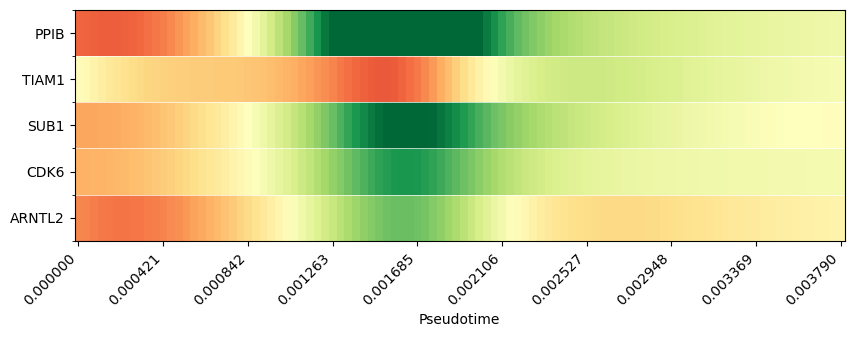

In [52]:
# Create figure for up-regulated genes
fig, ax = plt.subplots(figsize=(10, 3))
# Get genes from the up_regulated category
transient_down_genes = lf_classifications['transient_down']
# Plot expression gradient for up-regulated genes
fig, ax, cmap = fig_expression_gradient_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=2,
    genes_or_regulations=transient_down_genes,
    num=100,
    dist=0.0005,
    ax=ax,
    cmap="RdYlGn",
    figsize=(10, 0.3)
)

In [134]:
# combine the genes from the classifications into one filtered list
filtered_lf_genes = list(lf_classifications['up_regulated']) + list(lf_classifications['transient_up']) + list(lf_classifications['down_regulated']) + list(lf_classifications['transient_down'])

/tmp/ipykernel_7446/3425436304.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


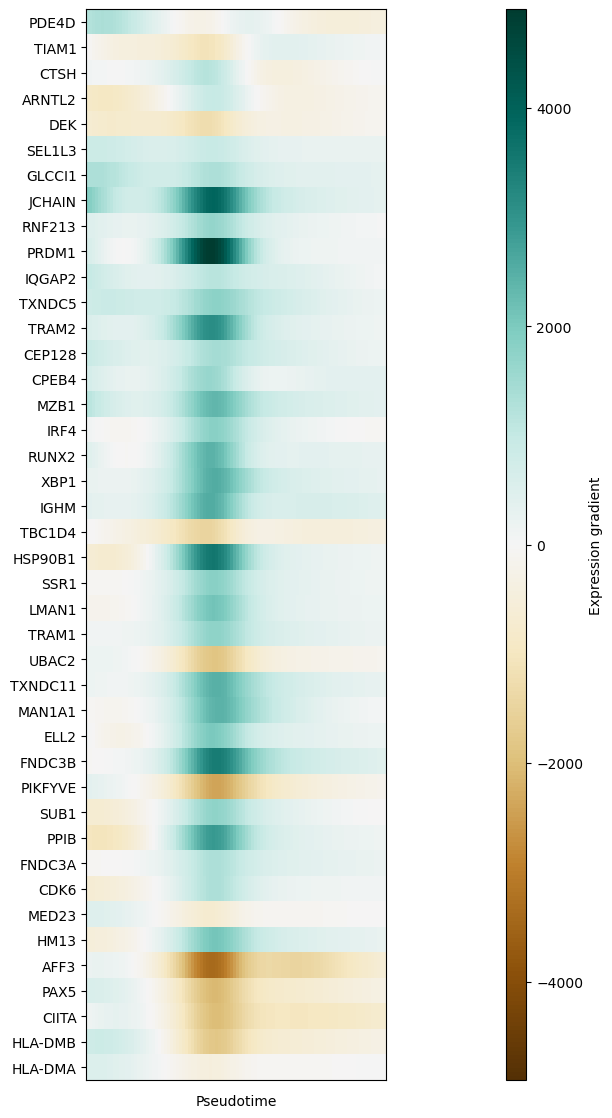

In [137]:
fig, gradients, ordered_genes = fig_clustered_expression_gradient_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=2,
    genes_or_regulations=filtered_lf_genes,
    dchar=lf_lcpm_dchar_pb,
    num=100,
    dist=0.0005,
    cmap='BrBG'
)

#### Normalization of beta characteristics

In [10]:
from scipy import stats
# Create example DataFrame
example_df = pd.DataFrame({
    'Terminal logFC': [2.5, -1.8, 0.2, 0.1, 3.0, -0.3, 0.1, 1.5, -2.0, 0.4],
    'Transient logFC': [0.3, 0.2, 1.8, -1.5, 0.4, 2.0, -1.7, 0.3, 0.2, -1.9]
}, index=[f'Gene_{i}' for i in range(10)])

# Approach 1: Direct Min-Max normalization of absolute values
example_df['abs_Terminal'] = np.abs(example_df['Terminal logFC'])
example_df['abs_Transient'] = np.abs(example_df['Transient logFC'])

example_df['norm_Terminal_direct'] = (example_df['abs_Terminal'] - example_df['abs_Terminal'].min()) / \
                                   (example_df['abs_Terminal'].max() - example_df['abs_Terminal'].min())
example_df['norm_Transient_direct'] = (example_df['abs_Transient'] - example_df['abs_Transient'].min()) / \
                                    (example_df['abs_Transient'].max() - example_df['abs_Transient'].min())
example_df['max_effect_direct'] = example_df[['norm_Terminal_direct', 'norm_Transient_direct']].max(axis=1)
example_df['rank_direct'] = example_df['max_effect_direct'].rank(ascending=False)
print(example_df)


        Terminal logFC  Transient logFC  abs_Terminal  abs_Transient  \
Gene_0             2.5              0.3           2.5            0.3   
Gene_1            -1.8              0.2           1.8            0.2   
Gene_2             0.2              1.8           0.2            1.8   
Gene_3             0.1             -1.5           0.1            1.5   
Gene_4             3.0              0.4           3.0            0.4   
Gene_5            -0.3              2.0           0.3            2.0   
Gene_6             0.1             -1.7           0.1            1.7   
Gene_7             1.5              0.3           1.5            0.3   
Gene_8            -2.0              0.2           2.0            0.2   
Gene_9             0.4             -1.9           0.4            1.9   

        norm_Terminal_direct  norm_Transient_direct  max_effect_direct  \
Gene_0              0.827586               0.055556           0.827586   
Gene_1              0.586207               0.000000        